In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle


import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import scipy
from scipy import interpolate
from scipy.stats import binned_statistic_2d
from scipy.ndimage.filters import gaussian_filter
from astropy.table import Table, Column, vstack, join

import palettable

cmap_1 = palettable.colorbrewer.sequential.Blues_7_r
cmap_2 = palettable.colorbrewer.sequential.OrRd_7_r
cmap_3 = palettable.colorbrewer.sequential.YlGn_7_r
cmap_4 = palettable.colorbrewer.sequential.Purples_7_r

cmap_list = [cmap_1, cmap_2, cmap_3, cmap_4]

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

In [3]:
import jianbing

from jianbing import hsc
from jianbing import utils
from jianbing import visual
from jianbing import scatter
from jianbing import catalog
from jianbing import wlensing

In [4]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

### TopN test demo

#### DSigma profiles of mock galaxies

In [5]:
sim_dsig = Table.read(os.path.join(sim_dir, 'sim_merge_all_dsig.fits'))

#### Pre-compute lensing results for HSC galaxies

In [6]:
# Pre-compute
s16a_precompute = os.path.join(data_dir, 'topn_public_s16a_medium_precompute.hdf5')

hsc_pre = Table.read(s16a_precompute, path='hsc_extra')

#### Pre-compute lensing results for randoms

In [7]:
# Lensing data using medium photo-z quality cut
s16a_lensing = os.path.join(data_dir, 's16a_weak_lensing_medium.hdf5')

# Random
s16a_rand = Table.read(s16a_lensing, path='random')

#### Pre-defined number density bins

In [8]:
topn_bins = Table.read(os.path.join(bin_dir, 'topn_bins.fits'))

#### Compute the $\Delta\Sigma$ profiles for a given halo mass proxy in all number density bins

- Here we use 100 kpc aperture stellar mass as example

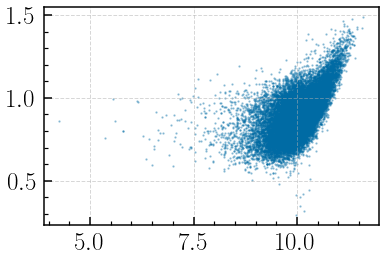

In [15]:
plt.scatter(hsc_pre['logm_50_100'][mask], np.log10(hsc_pre['r50_100'][mask]), s=2, alpha=0.3)

In [12]:
# S18A bright star mask
bsm_s18a = hsc_pre['flag'] > 0

# General mask for HSC galaxies
mask = (
    (hsc_pre['c82_100'] <= 18.) & (hsc_pre['logm_100'] - hsc_pre['logm_50'] <= 0.2) & (hsc_pre['logm_50_100'] > 0) &
    bsm_s18a
)

# General mask for HSC size measurements
size_mask = (
    mask & (hsc_pre['logm_max'] >= 11.3) & (hsc_pre['r80_100'] <= 60.0) & (hsc_pre['r90_100'] <= 60.0)
)

# Mask to select "central" galaxies
cen_mask_1 = hsc_pre['cen_mask_1'] > 0
cen_mask_2 = hsc_pre['cen_mask_2'] > 0
cen_mask_3 = hsc_pre['cen_mask_3'] > 0

In [21]:
hsc_test = wlensing.gather_topn_dsigma_profiles(
    hsc_pre, s16a_rand, topn_bins, 'logm_cmod', mask=(mask & cen_mask_3), n_rand=100000, n_boot=200, verbose=True)


# Using column: logm_cmod
# Bin 1:     0 -    52
# Bin 2:    53 -   248
# Bin 3:   224 -   817
# Bin 4:   818 -  1860


In [22]:
hsc_test_sum = scatter.compare_model_dsigma(
    hsc_test, sim_dsig, model_err=False, poly=True, verbose=True)

# Dealing with Bin: 1
# Dealing with Bin: 2
# Dealing with Bin: 3
# Dealing with Bin: 4


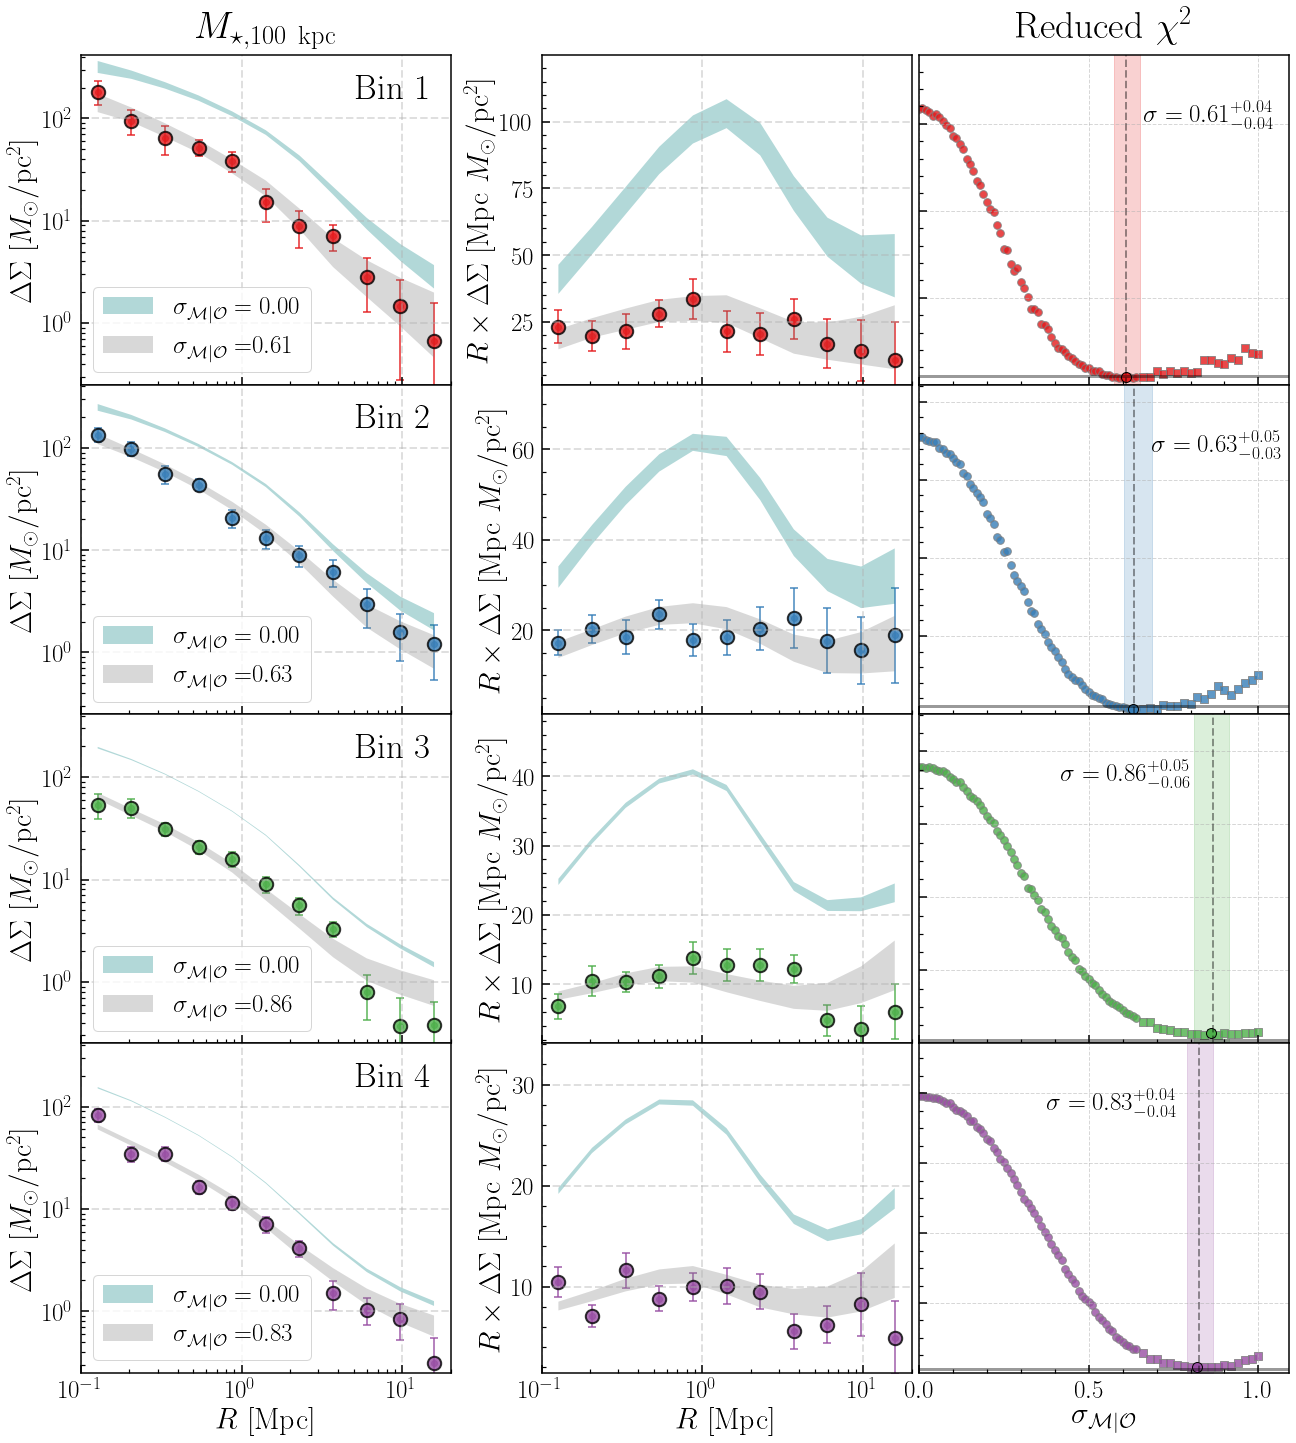

In [23]:
fig = visual.sum_plot_topn(
    hsc_test_sum, r'$M_{\star,100\ \rm kpc}$', note=None, cov_type='jk', ref_tab=None)

#### Making a special version for the paper

In [33]:
# DeltaSigma profiles of HSC massive galaxies
topn_massive = pickle.load(open(os.path.join(res_dir, 'topn_galaxies_sum.pkl'), 'rb'))

#### DSigma profiles of mock galaxies

In [34]:
sim_dsig = Table.read(os.path.join(sim_dir, 'sim_merge_all_dsig.fits'))

#### Halo mass distributions

In [35]:
sim_mhalo = Table.read(os.path.join(sim_dir, 'sim_merge_mhalo_hist.fits'))

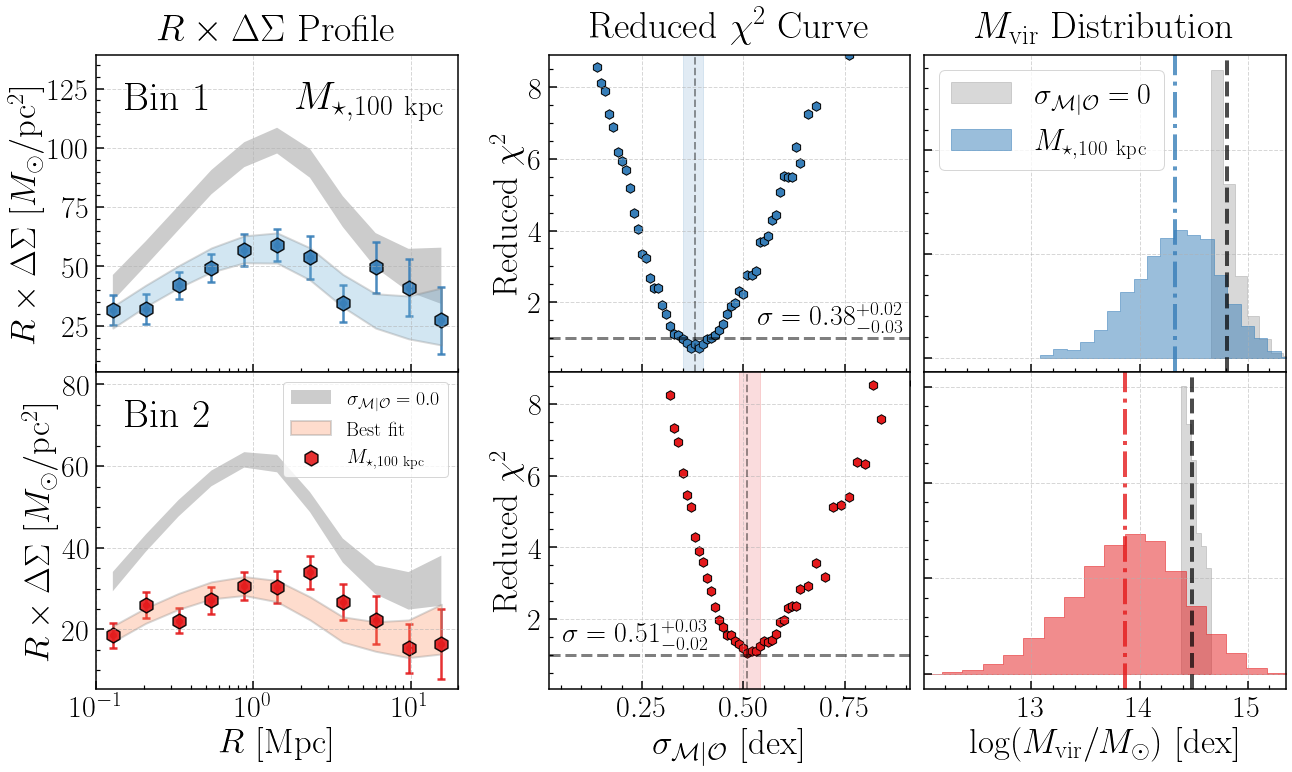

In [63]:
dsig_ref = topn_massive['logm_100'][0:2]
label_ref = r'$M_{\star,100\ \rm kpc}$'

# ---- Start the figure ---- #

n_col, n_bins = 3, len(dsig_ref)
left, right = 0.07, 0.98
bottom, top = 0.12, 0.92
x_space = 0.07
x_size = (right - left - x_space * 1.05) / n_col
y_size = (top - bottom) / n_bins

fig = plt.figure(figsize=(n_col * 6, n_bins * 5.5))
    
for bin_id in np.arange(n_bins) + 1:
    # Setup the three columns
    ax1 = fig.add_axes([left, top - y_size * bin_id, x_size, y_size])
    ax2 = fig.add_axes([left + x_space + x_size, top - y_size * bin_id, x_size, y_size])
    ax3 = fig.add_axes([left + x_space + x_size * 2.04, top - y_size * bin_id, x_size, y_size])
    
    # Subplot title
    if bin_id == 1:
        ax1.set_title(r'$R \times \Delta\Sigma\ \rm Profile$', fontsize=38, pad=18)
        ax2.set_title(r'$\rm Reduced\ \chi^2\ Curve$', fontsize=38, pad=18)
        ax3.set_title(r'$M_{\rm vir}\ \rm Distribution$', fontsize=38, pad=18)
    
    # Color map 
    cmap = cmap_list[bin_id - 1]
    color = color_bins[bin_id - 1]
    
    # DSigma result for this bin
    dsig_ref_bin = dsig_ref[bin_id - 1]
    
    sig_best = np.round(dsig_ref_bin['sig_med_bt'], 2)
    sig_upp = np.round(dsig_ref_bin['sig_upp_bt'], 2)
    sig_low = np.round(dsig_ref_bin['sig_low_bt'], 2)
    
    # ----- Plot 1: R x DSigma plot ----- #
    ax1.set_xscale("log", nonpositive='clip')
    
    r_mpc_obs = dsig_ref_bin.meta['r_mpc']
    r_mpc_mod = r_mpc_obs
    
    # MDPL: Sigma = 0.0
    err = (dsig_ref_bin['dsigma_sig0_bt'] - dsig_ref_bin['dsigma_sig0_low_bt']) * 5
    ax1.fill_between(
        r_mpc_mod,
        r_mpc_mod * (dsig_ref_bin['dsigma_sig0_bt'] - err),
        r_mpc_mod * (dsig_ref_bin['dsigma_sig0_bt'] + err),
        alpha=0.4, edgecolor='none', linestyle='--', linewidth=2.0, 
        label=r'$\sigma_{\mathcal{M} | \mathcal{O}}=0.0$',
        facecolor='grey', rasterized=True, zorder=0)

    # MDPL: Best-fit
    err = (dsig_ref_bin['dsigma_mod_bt'] - dsig_ref_bin['dsigma_mod_low_bt']) * 5
    ax1.fill_between(
        r_mpc_mod,
        r_mpc_mod * (dsig_ref_bin['dsigma_mod_bt'] - err),
        r_mpc_mod * (dsig_ref_bin['dsigma_mod_bt'] + err),
        alpha=0.3, edgecolor='grey', linewidth=2.0,
        label=r'$\rm Best\ fit$',
        facecolor=cmap.mpl_colormap(0.5), linestyle='-', rasterized=True) 
    
    # Reference DSigma profile
    ax1.errorbar(
        r_mpc_obs, r_mpc_obs * dsig_ref_bin['dsigma'],
        yerr=(r_mpc_obs * dsig_ref_bin['dsig_err_bt']),
        ecolor=color, color=color, alpha=0.9, capsize=4, capthick=2.5, elinewidth=2.5, 
        label='__no_label__', fmt='o', zorder=0)
    ax1.scatter(
        r_mpc_obs, r_mpc_obs * dsig_ref_bin['dsigma'],
        s=220, alpha=0.9, facecolor=color, edgecolor='k', marker='h', linewidth=1.5, label=label_ref)

    ax1.set_ylim(5.5, np.max(r_mpc_obs * dsig_ref_bin['dsigma_sig0_bt']) * 1.35)
    
    # Bin ID
    _ = ax1.text(0.08, 0.83, r'$\rm Bin\ {:1d}$'.format(bin_id), fontsize=40, 
                 transform=ax1.transAxes)
    
    if bin_id == 1:
        ax1.text(0.55, 0.83, label_ref, fontsize=40, transform=ax1.transAxes)
    
    if bin_id == n_bins:
        _ = ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=35)
        ax1.legend(loc='best', fontsize=20)
    else:
        ax1.set_xticklabels([])
    _ = ax1.set_ylabel(r'$R \times \Delta\Sigma\ [M_{\odot}/\mathrm{pc}^2]$', fontsize=35)


    # ----- Plot 2: Ratio of DSigma plot ----- #
    #ax2.set_xscale("log", nonpositive='clip')
    
    ax2.axhline(1.0, linewidth=3.0, alpha=0.5, color='k', linestyle='--', label='__no_label__', )
    
    ax2.scatter(dsig_ref_bin['sigma'], dsig_ref_bin['chi2_bt'] / 10, marker='h', s=90,
                facecolor=color, edgecolor='k', label='__no_label__')
    
    ax2.axvline(sig_best, linewidth=2.0, alpha=0.4, linestyle='--', color='k')
    ax2.fill_between([sig_low, sig_upp], [0, 0], [11.0, 11.0], color=color, alpha=0.15)

    if sig_best <= 0.45:
        _ = ax2.text(
            0.58, 0.15, 
            r'$\sigma={:4.2f}^{{+{:4.2f}}}_{{-{:4.2f}}}$'.format(
                sig_best, sig_upp - sig_best, sig_best - sig_low), 
            transform=ax2.transAxes, fontsize=28)
    else:
        _ = ax2.text(
            0.04, 0.15,
            r'$\sigma={:4.2f}^{{+{:4.2f}}}_{{-{:4.2f}}}$'.format(
                sig_best, sig_upp - sig_best, sig_best - sig_low),
            transform=ax2.transAxes, fontsize=28)

    ax2.set_xlim(0.02, 0.91)
    ax2.set_ylim(0.05, 8.9)
    
    if bin_id == bin_id:
        _ = ax2.set_xlabel(r'$\sigma_{\mathcal{M} | \mathcal{O}}\ [\rm dex]$', fontsize=35)
    else:
        ax2.set_xticklabels([])
    _ = ax2.set_ylabel(r'$\rm Reduced\ \chi^2$', fontsize=35)

    
    # ----- Plot 3: Halo mass distribution plot ----- #
    # Histogram for sigma = 0.0
    if bin_id == 1:
        hist_bins = 8
    elif bin_id == 2:
        hist_bins = 6
    else:
        hist_bins = 3
        
    sim_mhalo_bin = sim_mhalo[sim_mhalo['number_density_bin'] == bin_id - 1]
    mvir_true, hist_true, mvir_avg_true = catalog.rebin_mhalo_hist(
        sim_mhalo_bin, bin_id - 1, 0.0, n_bin=hist_bins)

    mvir_ref, hist_ref, mvir_avg_ref = catalog.rebin_mhalo_hist(
        sim_mhalo_bin, bin_id - 1, dsig_ref_bin['sig_med_bt'], n_bin=20)

    # Histogram for sigma = 0.0
    ax3.fill_between(mvir_true, hist_true / hist_true.sum() / 1.7, color='grey',
                     step="pre", alpha=0.3, label=r'$\sigma_{\mathcal{M} | \mathcal{O}}=0$', zorder=0)
    ax3.axvline(mvir_avg_true, color='k', alpha=0.7, linewidth=4.0, linestyle='--')

    # Halo mass distribution for the reference sample
    if bin_id == 2:
        ax3.fill_between(mvir_ref, hist_ref / hist_ref.sum() / 2, color=color,
                         step="pre", alpha=0.5, label=label_ref, zorder=1)
    else:
        ax3.fill_between(mvir_ref, hist_ref / hist_ref.sum(), color=color,
                         step="pre", alpha=0.5, label=label_ref, zorder=1)
    ax3.axvline(mvir_avg_ref, color=color, alpha=0.8, linewidth=4.0, linestyle='-.')

    
    ax3.set_xlim(12.01, 15.35)
    if bin_id == 1:
        ax3.legend(loc='best', fontsize=30)

    ax3.set_yticklabels([])
    if bin_id == n_bins:
        _ = ax3.set_xlabel(r'$\log(M_{\rm vir}/M_{\odot})\ [\rm dex]$', fontsize=35)
    else:
        ax3.set_xticklabels([])
        
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(30)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(30)

    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(30)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(30)

    for tick in ax3.xaxis.get_major_ticks():
        tick.label.set_fontsize(30)
    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(30)

In [64]:
fig.savefig(os.path.join(fig_dir, 'fig_A1.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_A1.pdf'), dpi=120)

### ASAP Mvir predictions

In [ ]:
hsc_pre['logmh_vir_plane']

In [24]:
hsc_test = wlensing.gather_topn_dsigma_profiles(
    hsc_pre, s16a_rand, topn_bins, 'logmh_vir_plane', mask=(mask & cen_mask_3), n_rand=100000, n_boot=200, verbose=True)


# Using column: logmh_vir_plane
# Bin 1:     0 -    52
# Bin 2:    53 -   248
# Bin 3:   224 -   817
# Bin 4:   818 -  1860


In [25]:
hsc_test_sum = scatter.compare_model_dsigma(
    hsc_test, sim_dsig, model_err=False, poly=True, verbose=True)

# Dealing with Bin: 1
# Dealing with Bin: 2
# Dealing with Bin: 3
# Dealing with Bin: 4


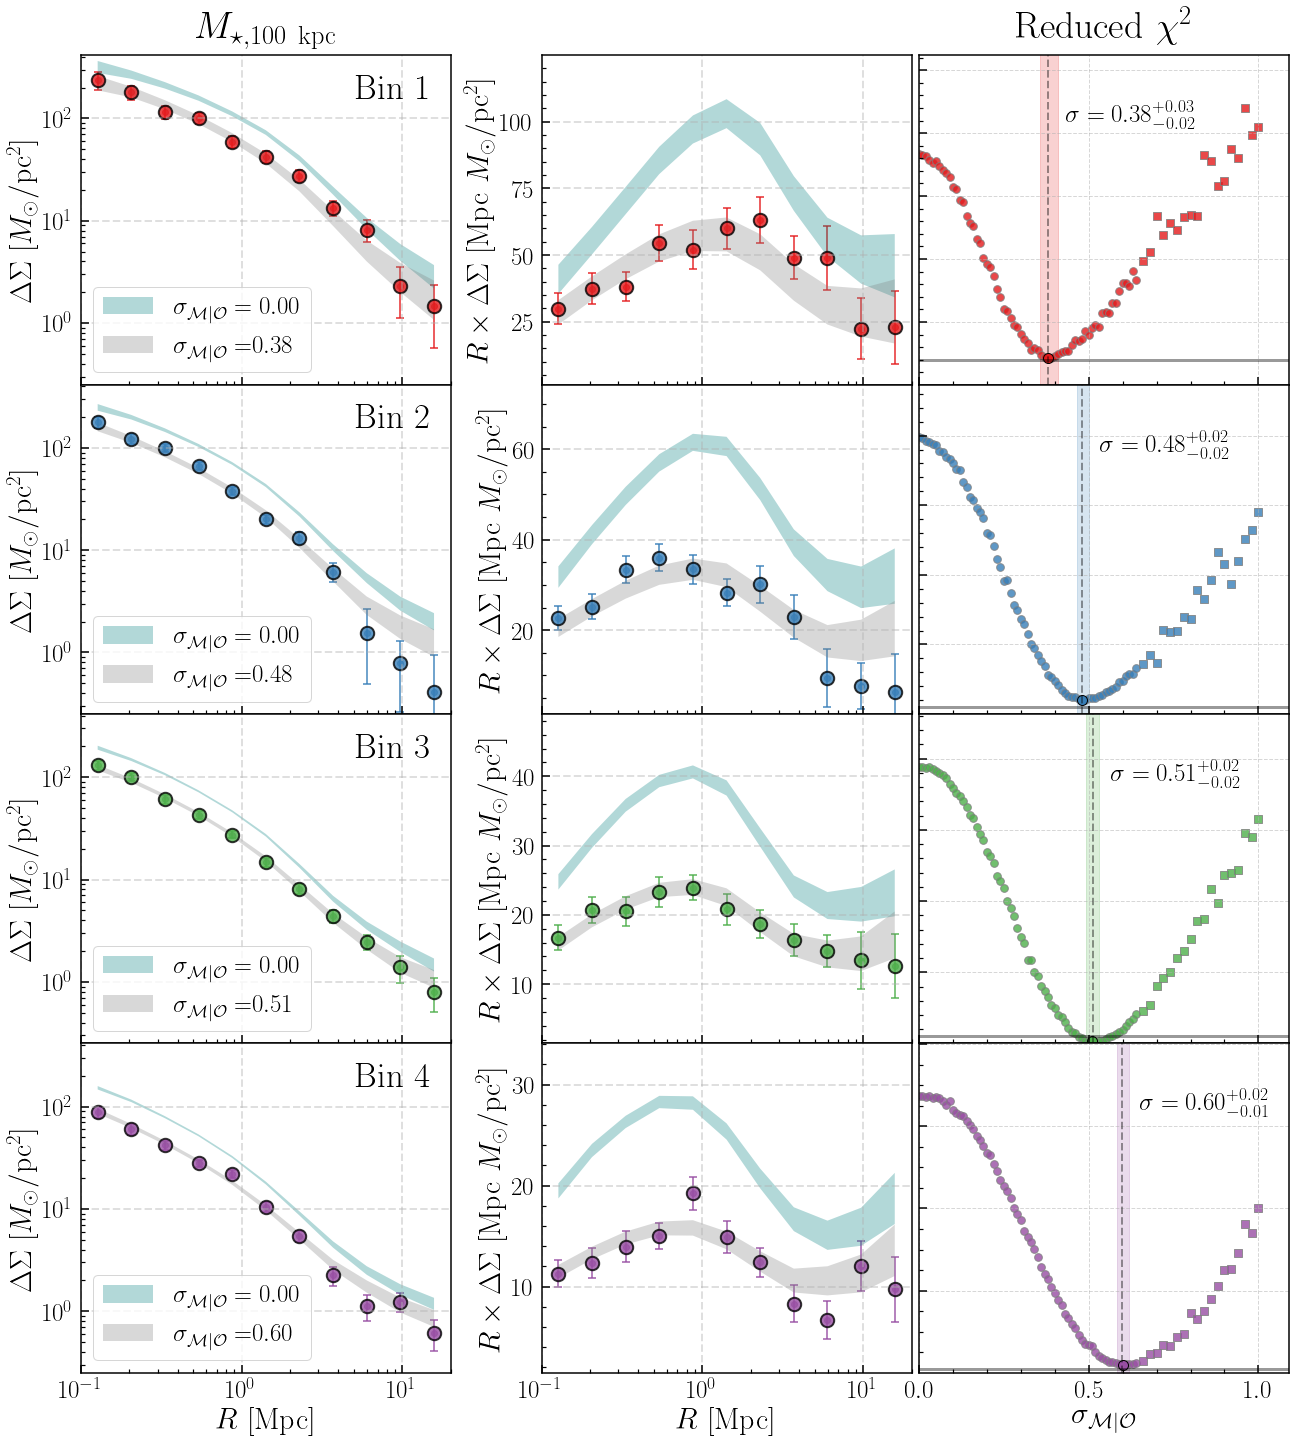

In [26]:
fig = visual.sum_plot_topn(
    hsc_test_sum, r'$M_{\rm Vir,\ ASAP}$', note=None, cov_type='jk', ref_tab=None)